<a href="https://colab.research.google.com/github/edouardrolland/Plume_Detection/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv8 Object Detection on a Custom Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/wuZtUMEiKWY)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is a popular version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## Disclaimer

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the accompanying [Blog Post](https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv8
- CLI Basics
- Inference with Pre-trained COCO Model
- Roboflow Universe
- Preparing a custom dataset
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Nov 24 15:30:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install YOLOv8

YOLOv8 can be installed in two ways - from the source and via pip. This is because it is the first iteration of YOLO to have an official package.

In [4]:
# Pip install method (recommended)

!pip install ultralytics==8.2.103 -q

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()


print(ultralytics.__file__)

##### The path displayed at the bottom let us know where you should apply the modifications to display the data.


Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)
/usr/local/lib/python3.10/dist-packages/ultralytics/__init__.py


In [14]:
!find /usr/local/lib/python3.10/dist-packages/ultralytics/ -name "metrics.py"


/usr/local/lib/python3.10/dist-packages/ultralytics/utils/metrics.py


In [19]:
import shutil
import os
import ultralytics

# Get the path to metrics.py (updated based on your ultralytics.__file__ path)
# Note: Adjust this path if necessary based on your actual environment
metrics_file = '/usr/local/lib/python3.10/dist-packages/ultralytics/utils/metrics.py'
source_path = os.path.dirname(metrics_file) + '/metrics.py'
destination_path = '/content/metrics.py'  # Temporary location

metrics.py modified successfully!


Here you have the metrics file with the correct data logging!

In [20]:
# Ultralytics YOLO 🚀, AGPL-3.0 license
"""Model validation metrics."""

import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

from ultralytics.utils import LOGGER, SimpleClass, TryExcept, plt_settings

OKS_SIGMA = (
    np.array([0.26, 0.25, 0.25, 0.35, 0.35, 0.79, 0.79, 0.72, 0.72, 0.62, 0.62, 1.07, 1.07, 0.87, 0.87, 0.89, 0.89])
    / 10.0
)


def bbox_ioa(box1, box2, iou=False, eps=1e-7):
    """
    Calculate the intersection over box2 area given box1 and box2. Boxes are in x1y1x2y2 format.

    Args:
        box1 (np.ndarray): A numpy array of shape (n, 4) representing n bounding boxes.
        box2 (np.ndarray): A numpy array of shape (m, 4) representing m bounding boxes.
        iou (bool): Calculate the standard IoU if True else return inter_area/box2_area.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (np.ndarray): A numpy array of shape (n, m) representing the intersection over box2 area.
    """
    # Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1.T
    b2_x1, b2_y1, b2_x2, b2_y2 = box2.T

    # Intersection area
    inter_area = (np.minimum(b1_x2[:, None], b2_x2) - np.maximum(b1_x1[:, None], b2_x1)).clip(0) * (
        np.minimum(b1_y2[:, None], b2_y2) - np.maximum(b1_y1[:, None], b2_y1)
    ).clip(0)

    # Box2 area
    area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
    if iou:
        box1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        area = area + box1_area[:, None] - inter_area

    # Intersection over box2 area
    return inter_area / (area + eps)


def box_iou(box1, box2, eps=1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes. Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Based on https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py.

    Args:
        box1 (torch.Tensor): A tensor of shape (N, 4) representing N bounding boxes.
        box2 (torch.Tensor): A tensor of shape (M, 4) representing M bounding boxes.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): An NxM tensor containing the pairwise IoU values for every element in box1 and box2.
    """
    # NOTE: Need .float() to get accurate iou values
    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.float().unsqueeze(1).chunk(2, 2), box2.float().unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)


def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):
    """
    Calculate Intersection over Union (IoU) of box1(1, 4) to box2(n, 4).

    Args:
        box1 (torch.Tensor): A tensor representing a single bounding box with shape (1, 4).
        box2 (torch.Tensor): A tensor representing n bounding boxes with shape (n, 4).
        xywh (bool, optional): If True, input boxes are in (x, y, w, h) format. If False, input boxes are in
                               (x1, y1, x2, y2) format. Defaults to True.
        GIoU (bool, optional): If True, calculate Generalized IoU. Defaults to False.
        DIoU (bool, optional): If True, calculate Distance IoU. Defaults to False.
        CIoU (bool, optional): If True, calculate Complete IoU. Defaults to False.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): IoU, GIoU, DIoU, or CIoU values depending on the specified flags.
    """
    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps

    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * (
        b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)
    ).clamp_(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU https://arxiv.org/abs/1911.08287v1
            c2 = cw.pow(2) + ch.pow(2) + eps  # convex diagonal squared
            rho2 = (
                (b2_x1 + b2_x2 - b1_x1 - b1_x2).pow(2) + (b2_y1 + b2_y2 - b1_y1 - b1_y2).pow(2)
            ) / 4  # center dist**2
            if CIoU:  # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
                v = (4 / math.pi**2) * ((w2 / h2).atan() - (w1 / h1).atan()).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area  # GIoU https://arxiv.org/pdf/1902.09630.pdf
    return iou  # IoU


def mask_iou(mask1, mask2, eps=1e-7):
    """
    Calculate masks IoU.

    Args:
        mask1 (torch.Tensor): A tensor of shape (N, n) where N is the number of ground truth objects and n is the
                        product of image width and height.
        mask2 (torch.Tensor): A tensor of shape (M, n) where M is the number of predicted objects and n is the
                        product of image width and height.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing masks IoU.
    """
    intersection = torch.matmul(mask1, mask2.T).clamp_(0)
    union = (mask1.sum(1)[:, None] + mask2.sum(1)[None]) - intersection  # (area1 + area2) - intersection
    return intersection / (union + eps)


def kpt_iou(kpt1, kpt2, area, sigma, eps=1e-7):
    """
    Calculate Object Keypoint Similarity (OKS).

    Args:
        kpt1 (torch.Tensor): A tensor of shape (N, 17, 3) representing ground truth keypoints.
        kpt2 (torch.Tensor): A tensor of shape (M, 17, 3) representing predicted keypoints.
        area (torch.Tensor): A tensor of shape (N,) representing areas from ground truth.
        sigma (list): A list containing 17 values representing keypoint scales.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing keypoint similarities.
    """
    d = (kpt1[:, None, :, 0] - kpt2[..., 0]).pow(2) + (kpt1[:, None, :, 1] - kpt2[..., 1]).pow(2)  # (N, M, 17)
    sigma = torch.tensor(sigma, device=kpt1.device, dtype=kpt1.dtype)  # (17, )
    kpt_mask = kpt1[..., 2] != 0  # (N, 17)
    e = d / ((2 * sigma).pow(2) * (area[:, None, None] + eps) * 2)  # from cocoeval
    # e = d / ((area[None, :, None] + eps) * sigma) ** 2 / 2  # from formula
    return ((-e).exp() * kpt_mask[:, None]).sum(-1) / (kpt_mask.sum(-1)[:, None] + eps)


def _get_covariance_matrix(boxes):
    """
    Generating covariance matrix from obbs.

    Args:
        boxes (torch.Tensor): A tensor of shape (N, 5) representing rotated bounding boxes, with xywhr format.

    Returns:
        (torch.Tensor): Covariance matrices corresponding to original rotated bounding boxes.
    """
    # Gaussian bounding boxes, ignore the center points (the first two columns) because they are not needed here.
    gbbs = torch.cat((boxes[:, 2:4].pow(2) / 12, boxes[:, 4:]), dim=-1)
    a, b, c = gbbs.split(1, dim=-1)
    cos = c.cos()
    sin = c.sin()
    cos2 = cos.pow(2)
    sin2 = sin.pow(2)
    return a * cos2 + b * sin2, a * sin2 + b * cos2, (a - b) * cos * sin


def probiou(obb1, obb2, CIoU=False, eps=1e-7):
    """
    Calculate probabilistic IoU between oriented bounding boxes.

    Implements the algorithm from https://arxiv.org/pdf/2106.06072v1.pdf.

    Args:
        obb1 (torch.Tensor): Ground truth OBBs, shape (N, 5), format xywhr.
        obb2 (torch.Tensor): Predicted OBBs, shape (N, 5), format xywhr.
        CIoU (bool, optional): If True, calculate CIoU. Defaults to False.
        eps (float, optional): Small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): OBB similarities, shape (N,).

    Note:
        OBB format: [center_x, center_y, width, height, rotation_angle].
        If CIoU is True, returns CIoU instead of IoU.
    """
    x1, y1 = obb1[..., :2].split(1, dim=-1)
    x2, y2 = obb2[..., :2].split(1, dim=-1)
    a1, b1, c1 = _get_covariance_matrix(obb1)
    a2, b2, c2 = _get_covariance_matrix(obb2)

    t1 = (
        ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)
    ) * 0.25
    t2 = (((c1 + c2) * (x2 - x1) * (y1 - y2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)) * 0.5
    t3 = (
        ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2))
        / (4 * ((a1 * b1 - c1.pow(2)).clamp_(0) * (a2 * b2 - c2.pow(2)).clamp_(0)).sqrt() + eps)
        + eps
    ).log() * 0.5
    bd = (t1 + t2 + t3).clamp(eps, 100.0)
    hd = (1.0 - (-bd).exp() + eps).sqrt()
    iou = 1 - hd
    if CIoU:  # only include the wh aspect ratio part
        w1, h1 = obb1[..., 2:4].split(1, dim=-1)
        w2, h2 = obb2[..., 2:4].split(1, dim=-1)
        v = (4 / math.pi**2) * ((w2 / h2).atan() - (w1 / h1).atan()).pow(2)
        with torch.no_grad():
            alpha = v / (v - iou + (1 + eps))
        return iou - v * alpha  # CIoU
    return iou


def batch_probiou(obb1, obb2, eps=1e-7):
    """
    Calculate the prob IoU between oriented bounding boxes, https://arxiv.org/pdf/2106.06072v1.pdf.

    Args:
        obb1 (torch.Tensor | np.ndarray): A tensor of shape (N, 5) representing ground truth obbs, with xywhr format.
        obb2 (torch.Tensor | np.ndarray): A tensor of shape (M, 5) representing predicted obbs, with xywhr format.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): A tensor of shape (N, M) representing obb similarities.
    """
    obb1 = torch.from_numpy(obb1) if isinstance(obb1, np.ndarray) else obb1
    obb2 = torch.from_numpy(obb2) if isinstance(obb2, np.ndarray) else obb2

    x1, y1 = obb1[..., :2].split(1, dim=-1)
    x2, y2 = (x.squeeze(-1)[None] for x in obb2[..., :2].split(1, dim=-1))
    a1, b1, c1 = _get_covariance_matrix(obb1)
    a2, b2, c2 = (x.squeeze(-1)[None] for x in _get_covariance_matrix(obb2))

    t1 = (
        ((a1 + a2) * (y1 - y2).pow(2) + (b1 + b2) * (x1 - x2).pow(2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)
    ) * 0.25
    t2 = (((c1 + c2) * (x2 - x1) * (y1 - y2)) / ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2) + eps)) * 0.5
    t3 = (
        ((a1 + a2) * (b1 + b2) - (c1 + c2).pow(2))
        / (4 * ((a1 * b1 - c1.pow(2)).clamp_(0) * (a2 * b2 - c2.pow(2)).clamp_(0)).sqrt() + eps)
        + eps
    ).log() * 0.5
    bd = (t1 + t2 + t3).clamp(eps, 100.0)
    hd = (1.0 - (-bd).exp() + eps).sqrt()
    return 1 - hd


def smooth_BCE(eps=0.1):
    """
    Computes smoothed positive and negative Binary Cross-Entropy targets.

    This function calculates positive and negative label smoothing BCE targets based on a given epsilon value.
    For implementation details, refer to https://github.com/ultralytics/yolov3/issues/238#issuecomment-598028441.

    Args:
        eps (float, optional): The epsilon value for label smoothing. Defaults to 0.1.

    Returns:
        (tuple): A tuple containing the positive and negative label smoothing BCE targets.
    """
    return 1.0 - 0.5 * eps, 0.5 * eps


class ConfusionMatrix:
    """
    A class for calculating and updating a confusion matrix for object detection and classification tasks.

    Attributes:
        task (str): The type of task, either 'detect' or 'classify'.
        matrix (np.ndarray): The confusion matrix, with dimensions depending on the task.
        nc (int): The number of classes.
        conf (float): The confidence threshold for detections.
        iou_thres (float): The Intersection over Union threshold.
    """

    def __init__(self, nc, conf=0.25, iou_thres=0.45, task="detect"):
        """Initialize attributes for the YOLO model."""
        self.task = task
        self.matrix = np.zeros((nc + 1, nc + 1)) if self.task == "detect" else np.zeros((nc, nc))
        self.nc = nc  # number of classes
        self.conf = 0.25 if conf in {None, 0.001} else conf  # apply 0.25 if default val conf is passed
        self.iou_thres = iou_thres

    def process_cls_preds(self, preds, targets):
        """
        Update confusion matrix for classification task.

        Args:
            preds (Array[N, min(nc,5)]): Predicted class labels.
            targets (Array[N, 1]): Ground truth class labels.
        """
        preds, targets = torch.cat(preds)[:, 0], torch.cat(targets)
        for p, t in zip(preds.cpu().numpy(), targets.cpu().numpy()):
            self.matrix[p][t] += 1

    def process_batch(self, detections, gt_bboxes, gt_cls):
        """
        Update confusion matrix for object detection task.

        Args:
            detections (Array[N, 6] | Array[N, 7]): Detected bounding boxes and their associated information.
                                      Each row should contain (x1, y1, x2, y2, conf, class)
                                      or with an additional element `angle` when it's obb.
            gt_bboxes (Array[M, 4]| Array[N, 5]): Ground truth bounding boxes with xyxy/xyxyr format.
            gt_cls (Array[M]): The class labels.
        """
        if gt_cls.shape[0] == 0:  # Check if labels is empty
            if detections is not None:
                detections = detections[detections[:, 4] > self.conf]
                detection_classes = detections[:, 5].int()
                for dc in detection_classes:
                    self.matrix[dc, self.nc] += 1  # false positives
            return
        if detections is None:
            gt_classes = gt_cls.int()
            for gc in gt_classes:
                self.matrix[self.nc, gc] += 1  # background FN
            return

        detections = detections[detections[:, 4] > self.conf]
        gt_classes = gt_cls.int()
        detection_classes = detections[:, 5].int()
        is_obb = detections.shape[1] == 7 and gt_bboxes.shape[1] == 5  # with additional `angle` dimension
        iou = (
            batch_probiou(gt_bboxes, torch.cat([detections[:, :4], detections[:, -1:]], dim=-1))
            if is_obb
            else box_iou(gt_bboxes, detections[:, :4])
        )

        x = torch.where(iou > self.iou_thres)
        if x[0].shape[0]:
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
        else:
            matches = np.zeros((0, 3))

        n = matches.shape[0] > 0
        m0, m1, _ = matches.transpose().astype(int)
        for i, gc in enumerate(gt_classes):
            j = m0 == i
            if n and sum(j) == 1:
                self.matrix[detection_classes[m1[j]], gc] += 1  # correct
            else:
                self.matrix[self.nc, gc] += 1  # true background

        if n:
            for i, dc in enumerate(detection_classes):
                if not any(m1 == i):
                    self.matrix[dc, self.nc] += 1  # predicted background

    def matrix(self):
        """Returns the confusion matrix."""
        return self.matrix

    def tp_fp(self):
        """Returns true positives and false positives."""
        tp = self.matrix.diagonal()  # true positives
        fp = self.matrix.sum(1) - tp  # false positives
        # fn = self.matrix.sum(0) - tp  # false negatives (missed detections)
        return (tp[:-1], fp[:-1]) if self.task == "detect" else (tp, fp)  # remove background class if task=detect

    @TryExcept("WARNING ⚠️ ConfusionMatrix plot failure")
    @plt_settings()
    def plot(self, normalize=True, save_dir="", names=(), on_plot=None):
        """
        Plot the confusion matrix using seaborn and save it to a file.

        Args:
            normalize (bool): Whether to normalize the confusion matrix.
            save_dir (str): Directory where the plot will be saved.
            names (tuple): Names of classes, used as labels on the plot.
            on_plot (func): An optional callback to pass plots path and data when they are rendered.
        """
        import seaborn  # scope for faster 'import ultralytics'

        array = self.matrix / ((self.matrix.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
        array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

        fig, ax = plt.subplots(1, 1, figsize=(12, 9), tight_layout=True)
        nc, nn = self.nc, len(names)  # number of classes, names
        seaborn.set_theme(font_scale=1.0 if nc < 50 else 0.8)  # for label size
        labels = (0 < nn < 99) and (nn == nc)  # apply names to ticklabels
        ticklabels = (list(names) + ["background"]) if labels else "auto"
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
            seaborn.heatmap(
                array,
                ax=ax,
                annot=nc < 30,
                annot_kws={"size": 8},
                cmap="Blues",
                fmt=".2f" if normalize else ".0f",
                square=True,
                vmin=0.0,
                xticklabels=ticklabels,
                yticklabels=ticklabels,
            ).set_facecolor((1, 1, 1))
        title = "Confusion Matrix" + " Normalized" * normalize
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.set_title(title)
        plot_fname = Path(save_dir) / f'{title.lower().replace(" ", "_")}.png'
        fig.savefig(plot_fname, dpi=250)
        plt.close(fig)
        if on_plot:
            on_plot(plot_fname)

    def print(self):
        """Print the confusion matrix to the console."""
        for i in range(self.nc + 1):
            LOGGER.info(" ".join(map(str, self.matrix[i])))


def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode="valid")  # y-smoothed


@plt_settings()
def plot_pr_curve(px, py, ap, save_dir=Path("pr_curve.png"), names={}, on_plot=None):
    """Plots a precision-recall curve."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
    py = np.stack(py, axis=1)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth=1, label=f"{names[i]} {ap[i, 0]:.3f}")  # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth=1, color="grey")  # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth=3, color="blue", label=f"all classes {ap[:, 0].mean():.3f} mAP@0.5")
    data_points = np.column_stack((px, py.mean(1)))
    np.savetxt(save_dir.with_suffix(".csv"), data_points, delimiter=",")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("Precision-Recall Curve")
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)


@plt_settings()
def plot_mc_curve(px, py, save_dir=Path("mc_curve.png"), names={}, xlabel="Confidence", ylabel="Metric", on_plot=None):
    """Plots a metric-confidence curve."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f"{names[i]}")  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color="grey")  # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth=3, color="blue", label=f"all classes {y.max():.2f} at {px[y.argmax()]:.3f}")
    data_points = np.column_stack((px, y))
    np.savetxt(save_dir.with_suffix(".csv"), data_points, delimiter=",")

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title(f"{ylabel}-Confidence Curve")
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)


def compute_ap(recall, precision):
    """
    Compute the average precision (AP) given the recall and precision curves.

    Args:
        recall (list): The recall curve.
        precision (list): The precision curve.

    Returns:
        (float): Average precision.
        (np.ndarray): Precision envelope curve.
        (np.ndarray): Modified recall curve with sentinel values added at the beginning and end.
    """
    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec


def ap_per_class(
    tp, conf, pred_cls, target_cls, plot=False, on_plot=None, save_dir=Path(), names={}, eps=1e-16, prefix=""
):
    """
    Computes the average precision per class for object detection evaluation.

    Args:
        tp (np.ndarray): Binary array indicating whether the detection is correct (True) or not (False).
        conf (np.ndarray): Array of confidence scores of the detections.
        pred_cls (np.ndarray): Array of predicted classes of the detections.
        target_cls (np.ndarray): Array of true classes of the detections.
        plot (bool, optional): Whether to plot PR curves or not. Defaults to False.
        on_plot (func, optional): A callback to pass plots path and data when they are rendered. Defaults to None.
        save_dir (Path, optional): Directory to save the PR curves. Defaults to an empty path.
        names (dict, optional): Dict of class names to plot PR curves. Defaults to an empty tuple.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-16.
        prefix (str, optional): A prefix string for saving the plot files. Defaults to an empty string.

    Returns:
        (tuple): A tuple of six arrays and one array of unique classes, where:
            tp (np.ndarray): True positive counts at threshold given by max F1 metric for each class.Shape: (nc,).
            fp (np.ndarray): False positive counts at threshold given by max F1 metric for each class. Shape: (nc,).
            p (np.ndarray): Precision values at threshold given by max F1 metric for each class. Shape: (nc,).
            r (np.ndarray): Recall values at threshold given by max F1 metric for each class. Shape: (nc,).
            f1 (np.ndarray): F1-score values at threshold given by max F1 metric for each class. Shape: (nc,).
            ap (np.ndarray): Average precision for each class at different IoU thresholds. Shape: (nc, 10).
            unique_classes (np.ndarray): An array of unique classes that have data. Shape: (nc,).
            p_curve (np.ndarray): Precision curves for each class. Shape: (nc, 1000).
            r_curve (np.ndarray): Recall curves for each class. Shape: (nc, 1000).
            f1_curve (np.ndarray): F1-score curves for each class. Shape: (nc, 1000).
            x (np.ndarray): X-axis values for the curves. Shape: (1000,).
            prec_values: Precision values at mAP@0.5 for each class. Shape: (nc, 1000).
    """
    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    x, prec_values = np.linspace(0, 1, 1000), []

    # Average precision, precision and recall curves
    ap, p_curve, r_curve = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci]  # number of labels
        n_p = i.sum()  # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        r_curve[ci] = np.interp(-x, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p_curve[ci] = np.interp(-x, -conf[i], precision[:, 0], left=1)  # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                prec_values.append(np.interp(x, mrec, mpre))  # precision at mAP@0.5

    prec_values = np.array(prec_values)  # (nc, 1000)

    # Compute F1 (harmonic mean of precision and recall)
    f1_curve = 2 * p_curve * r_curve / (p_curve + r_curve + eps)
    names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
    names = dict(enumerate(names))  # to dict
    if plot:
        plot_pr_curve(x, prec_values, ap, save_dir / f"{prefix}PR_curve.png", names, on_plot=on_plot)
        plot_mc_curve(x, f1_curve, save_dir / f"{prefix}F1_curve.png", names, ylabel="F1", on_plot=on_plot)
        plot_mc_curve(x, p_curve, save_dir / f"{prefix}P_curve.png", names, ylabel="Precision", on_plot=on_plot)
        plot_mc_curve(x, r_curve, save_dir / f"{prefix}R_curve.png", names, ylabel="Recall", on_plot=on_plot)

    i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p_curve[:, i], r_curve[:, i], f1_curve[:, i]  # max-F1 precision, recall, F1 values
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    return tp, fp, p, r, f1, ap, unique_classes.astype(int), p_curve, r_curve, f1_curve, x, prec_values


class Metric(SimpleClass):
    """
    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    """

    def __init__(self) -> None:
        """Initializes a Metric instance for computing evaluation metrics for the YOLOv8 model."""
        self.p = []  # (nc, )
        self.r = []  # (nc, )
        self.f1 = []  # (nc, )
        self.all_ap = []  # (nc, 10)
        self.ap_class_index = []  # (nc, )
        self.nc = 0

    @property
    def ap50(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50 values per class, or an empty list if not available.
        """
        return self.all_ap[:, 0] if len(self.all_ap) else []

    @property
    def ap(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5-0.95 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50-95 values per class, or an empty list if not available.
        """
        return self.all_ap.mean(1) if len(self.all_ap) else []

    @property
    def mp(self):
        """
        Returns the Mean Precision of all classes.

        Returns:
            (float): The mean precision of all classes.
        """
        return self.p.mean() if len(self.p) else 0.0

    @property
    def mr(self):
        """
        Returns the Mean Recall of all classes.

        Returns:
            (float): The mean recall of all classes.
        """
        return self.r.mean() if len(self.r) else 0.0

    @property
    def map50(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.5.

        Returns:
            (float): The mAP at an IoU threshold of 0.5.
        """
        return self.all_ap[:, 0].mean() if len(self.all_ap) else 0.0

    @property
    def map75(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.75.

        Returns:
            (float): The mAP at an IoU threshold of 0.75.
        """
        return self.all_ap[:, 5].mean() if len(self.all_ap) else 0.0

    @property
    def map(self):
        """
        Returns the mean Average Precision (mAP) over IoU thresholds of 0.5 - 0.95 in steps of 0.05.

        Returns:
            (float): The mAP over IoU thresholds of 0.5 - 0.95 in steps of 0.05.
        """
        return self.all_ap.mean() if len(self.all_ap) else 0.0

    def mean_results(self):
        """Mean of results, return mp, mr, map50, map."""
        return [self.mp, self.mr, self.map50, self.map]

    def class_result(self, i):
        """Class-aware result, return p[i], r[i], ap50[i], ap[i]."""
        return self.p[i], self.r[i], self.ap50[i], self.ap[i]

    @property
    def maps(self):
        """MAP of each class."""
        maps = np.zeros(self.nc) + self.map
        for i, c in enumerate(self.ap_class_index):
            maps[c] = self.ap[i]
        return maps

    def fitness(self):
        """Model fitness as a weighted combination of metrics."""
        w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
        return (np.array(self.mean_results()) * w).sum()

    def update(self, results):
        """
        Updates the evaluation metrics of the model with a new set of results.

        Args:
            results (tuple): A tuple containing the following evaluation metrics:
                - p (list): Precision for each class. Shape: (nc,).
                - r (list): Recall for each class. Shape: (nc,).
                - f1 (list): F1 score for each class. Shape: (nc,).
                - all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
                - ap_class_index (list): Index of class for each AP score. Shape: (nc,).

        Side Effects:
            Updates the class attributes `self.p`, `self.r`, `self.f1`, `self.all_ap`, and `self.ap_class_index` based
            on the values provided in the `results` tuple.
        """
        (
            self.p,
            self.r,
            self.f1,
            self.all_ap,
            self.ap_class_index,
            self.p_curve,
            self.r_curve,
            self.f1_curve,
            self.px,
            self.prec_values,
        ) = results

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []

    @property
    def curves_results(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return [
            [self.px, self.prec_values, "Recall", "Precision"],
            [self.px, self.f1_curve, "Confidence", "F1"],
            [self.px, self.p_curve, "Confidence", "Precision"],
            [self.px, self.r_curve, "Confidence", "Recall"],
        ]


class DetMetrics(SimpleClass):
    """
    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    """

    def __init__(self, save_dir=Path("."), plot=False, on_plot=None, names={}) -> None:
        """Initialize a DetMetrics instance with a save directory, plot flag, callback function, and class names."""
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "detect"

    def process(self, tp, conf, pred_cls, target_cls):
        """Process predicted results for object detection and update metrics."""
        results = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            save_dir=self.save_dir,
            names=self.names,
            on_plot=self.on_plot,
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results)

    @property
    def keys(self):
        """Returns a list of keys for accessing specific metrics."""
        return ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

    def mean_results(self):
        """Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95."""
        return self.box.mean_results()

    def class_result(self, i):
        """Return the result of evaluating the performance of an object detection model on a specific class."""
        return self.box.class_result(i)

    @property
    def maps(self):
        """Returns mean Average Precision (mAP) scores per class."""
        return self.box.maps

    @property
    def fitness(self):
        """Returns the fitness of box object."""
        return self.box.fitness()

    @property
    def ap_class_index(self):
        """Returns the average precision index per class."""
        return self.box.ap_class_index

    @property
    def results_dict(self):
        """Returns dictionary of computed performance metrics and statistics."""
        return dict(zip(self.keys + ["fitness"], self.mean_results() + [self.fitness]))

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return ["Precision-Recall(B)", "F1-Confidence(B)", "Precision-Confidence(B)", "Recall-Confidence(B)"]

    @property
    def curves_results(self):
        """Returns dictionary of computed performance metrics and statistics."""
        return self.box.curves_results


class SegmentMetrics(SimpleClass):
    """
    Calculates and aggregates detection and segmentation metrics over a given set of classes.

    Args:
        save_dir (Path): Path to the directory where the output plots should be saved. Default is the current directory.
        plot (bool): Whether to save the detection and segmentation plots. Default is False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (list): List of class names. Default is an empty list.

    Attributes:
        save_dir (Path): Path to the directory where the output plots should be saved.
        plot (bool): Whether to save the detection and segmentation plots.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (list): List of class names.
        box (Metric): An instance of the Metric class to calculate box detection metrics.
        seg (Metric): An instance of the Metric class to calculate mask segmentation metrics.
        speed (dict): Dictionary to store the time taken in different phases of inference.

    Methods:
        process(tp_m, tp_b, conf, pred_cls, target_cls): Processes metrics over the given set of predictions.
        mean_results(): Returns the mean of the detection and segmentation metrics over all the classes.
        class_result(i): Returns the detection and segmentation metrics of class `i`.
        maps: Returns the mean Average Precision (mAP) scores for IoU thresholds ranging from 0.50 to 0.95.
        fitness: Returns the fitness scores, which are a single weighted combination of metrics.
        ap_class_index: Returns the list of indices of classes used to compute Average Precision (AP).
        results_dict: Returns the dictionary containing all the detection and segmentation metrics and fitness score.
    """

    def __init__(self, save_dir=Path("."), plot=False, on_plot=None, names=()) -> None:
        """Initialize a SegmentMetrics instance with a save directory, plot flag, callback function, and class names."""
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.seg = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "segment"

    def process(self, tp, tp_m, conf, pred_cls, target_cls):
        """
        Processes the detection and segmentation metrics over the given set of predictions.

        Args:
            tp (list): List of True Positive boxes.
            tp_m (list): List of True Positive masks.
            conf (list): List of confidence scores.
            pred_cls (list): List of predicted classes.
            target_cls (list): List of target classes.
        """
        results_mask = ap_per_class(
            tp_m,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            on_plot=self.on_plot,
            save_dir=self.save_dir,
            names=self.names,
            prefix="Mask",
        )[2:]
        self.seg.nc = len(self.names)
        self.seg.update(results_mask)
        results_box = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            on_plot=self.on_plot,
            save_dir=self.save_dir,
            names=self.names,
            prefix="Box",
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results_box)

    @property
    def keys(self):
        """Returns a list of keys for accessing metrics."""
        return [
            "metrics/precision(B)",
            "metrics/recall(B)",
            "metrics/mAP50(B)",
            "metrics/mAP50-95(B)",
            "metrics/precision(M)",
            "metrics/recall(M)",
            "metrics/mAP50(M)",
            "metrics/mAP50-95(M)",
        ]

    def mean_results(self):
        """Return the mean metrics for bounding box and segmentation results."""
        return self.box.mean_results() + self.seg.mean_results()

    def class_result(self, i):
        """Returns classification results for a specified class index."""
        return self.box.class_result(i) + self.seg.class_result(i)

    @property
    def maps(self):
        """Returns mAP scores for object detection and semantic segmentation models."""
        return self.box.maps + self.seg.maps

    @property
    def fitness(self):
        """Get the fitness score for both segmentation and bounding box models."""
        return self.seg.fitness() + self.box.fitness()

    @property
    def ap_class_index(self):
        """Boxes and masks have the same ap_class_index."""
        return self.box.ap_class_index

    @property
    def results_dict(self):
        """Returns results of object detection model for evaluation."""
        return dict(zip(self.keys + ["fitness"], self.mean_results() + [self.fitness]))

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return [
            "Precision-Recall(B)",
            "F1-Confidence(B)",
            "Precision-Confidence(B)",
            "Recall-Confidence(B)",
            "Precision-Recall(M)",
            "F1-Confidence(M)",
            "Precision-Confidence(M)",
            "Recall-Confidence(M)",
        ]

    @property
    def curves_results(self):
        """Returns dictionary of computed performance metrics and statistics."""
        return self.box.curves_results + self.seg.curves_results


class PoseMetrics(SegmentMetrics):
    """
    Calculates and aggregates detection and pose metrics over a given set of classes.

    Args:
        save_dir (Path): Path to the directory where the output plots should be saved. Default is the current directory.
        plot (bool): Whether to save the detection and segmentation plots. Default is False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (list): List of class names. Default is an empty list.

    Attributes:
        save_dir (Path): Path to the directory where the output plots should be saved.
        plot (bool): Whether to save the detection and segmentation plots.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (list): List of class names.
        box (Metric): An instance of the Metric class to calculate box detection metrics.
        pose (Metric): An instance of the Metric class to calculate mask segmentation metrics.
        speed (dict): Dictionary to store the time taken in different phases of inference.

    Methods:
        process(tp_m, tp_b, conf, pred_cls, target_cls): Processes metrics over the given set of predictions.
        mean_results(): Returns the mean of the detection and segmentation metrics over all the classes.
        class_result(i): Returns the detection and segmentation metrics of class `i`.
        maps: Returns the mean Average Precision (mAP) scores for IoU thresholds ranging from 0.50 to 0.95.
        fitness: Returns the fitness scores, which are a single weighted combination of metrics.
        ap_class_index: Returns the list of indices of classes used to compute Average Precision (AP).
        results_dict: Returns the dictionary containing all the detection and segmentation metrics and fitness score.
    """

    def __init__(self, save_dir=Path("."), plot=False, on_plot=None, names=()) -> None:
        """Initialize the PoseMetrics class with directory path, class names, and plotting options."""
        super().__init__(save_dir, plot, names)
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.pose = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "pose"

    def process(self, tp, tp_p, conf, pred_cls, target_cls):
        """
        Processes the detection and pose metrics over the given set of predictions.

        Args:
            tp (list): List of True Positive boxes.
            tp_p (list): List of True Positive keypoints.
            conf (list): List of confidence scores.
            pred_cls (list): List of predicted classes.
            target_cls (list): List of target classes.
        """
        results_pose = ap_per_class(
            tp_p,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            on_plot=self.on_plot,
            save_dir=self.save_dir,
            names=self.names,
            prefix="Pose",
        )[2:]
        self.pose.nc = len(self.names)
        self.pose.update(results_pose)
        results_box = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            on_plot=self.on_plot,
            save_dir=self.save_dir,
            names=self.names,
            prefix="Box",
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results_box)

    @property
    def keys(self):
        """Returns list of evaluation metric keys."""
        return [
            "metrics/precision(B)",
            "metrics/recall(B)",
            "metrics/mAP50(B)",
            "metrics/mAP50-95(B)",
            "metrics/precision(P)",
            "metrics/recall(P)",
            "metrics/mAP50(P)",
            "metrics/mAP50-95(P)",
        ]

    def mean_results(self):
        """Return the mean results of box and pose."""
        return self.box.mean_results() + self.pose.mean_results()

    def class_result(self, i):
        """Return the class-wise detection results for a specific class i."""
        return self.box.class_result(i) + self.pose.class_result(i)

    @property
    def maps(self):
        """Returns the mean average precision (mAP) per class for both box and pose detections."""
        return self.box.maps + self.pose.maps

    @property
    def fitness(self):
        """Computes classification metrics and speed using the `targets` and `pred` inputs."""
        return self.pose.fitness() + self.box.fitness()

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return [
            "Precision-Recall(B)",
            "F1-Confidence(B)",
            "Precision-Confidence(B)",
            "Recall-Confidence(B)",
            "Precision-Recall(P)",
            "F1-Confidence(P)",
            "Precision-Confidence(P)",
            "Recall-Confidence(P)",
        ]

    @property
    def curves_results(self):
        """Returns dictionary of computed performance metrics and statistics."""
        return self.box.curves_results + self.pose.curves_results


class ClassifyMetrics(SimpleClass):
    """
    Class for computing classification metrics including top-1 and top-5 accuracy.

    Attributes:
        top1 (float): The top-1 accuracy.
        top5 (float): The top-5 accuracy.
        speed (Dict[str, float]): A dictionary containing the time taken for each step in the pipeline.
        fitness (float): The fitness of the model, which is equal to top-5 accuracy.
        results_dict (Dict[str, Union[float, str]]): A dictionary containing the classification metrics and fitness.
        keys (List[str]): A list of keys for the results_dict.

    Methods:
        process(targets, pred): Processes the targets and predictions to compute classification metrics.
    """

    def __init__(self) -> None:
        """Initialize a ClassifyMetrics instance."""
        self.top1 = 0
        self.top5 = 0
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "classify"

    def process(self, targets, pred):
        """Target classes and predicted classes."""
        pred, targets = torch.cat(pred), torch.cat(targets)
        correct = (targets[:, None] == pred).float()
        acc = torch.stack((correct[:, 0], correct.max(1).values), dim=1)  # (top1, top5) accuracy
        self.top1, self.top5 = acc.mean(0).tolist()

    @property
    def fitness(self):
        """Returns mean of top-1 and top-5 accuracies as fitness score."""
        return (self.top1 + self.top5) / 2

    @property
    def results_dict(self):
        """Returns a dictionary with model's performance metrics and fitness score."""
        return dict(zip(self.keys + ["fitness"], [self.top1, self.top5, self.fitness]))

    @property
    def keys(self):
        """Returns a list of keys for the results_dict property."""
        return ["metrics/accuracy_top1", "metrics/accuracy_top5"]

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []

    @property
    def curves_results(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []


class OBBMetrics(SimpleClass):
    """Metrics for evaluating oriented bounding box (OBB) detection, see https://arxiv.org/pdf/2106.06072.pdf."""

    def __init__(self, save_dir=Path("."), plot=False, on_plot=None, names=()) -> None:
        """Initialize an OBBMetrics instance with directory, plotting, callback, and class names."""
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}

    def process(self, tp, conf, pred_cls, target_cls):
        """Process predicted results for object detection and update metrics."""
        results = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot=self.plot,
            save_dir=self.save_dir,
            names=self.names,
            on_plot=self.on_plot,
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results)

    @property
    def keys(self):
        """Returns a list of keys for accessing specific metrics."""
        return ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

    def mean_results(self):
        """Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95."""
        return self.box.mean_results()

    def class_result(self, i):
        """Return the result of evaluating the performance of an object detection model on a specific class."""
        return self.box.class_result(i)

    @property
    def maps(self):
        """Returns mean Average Precision (mAP) scores per class."""
        return self.box.maps

    @property
    def fitness(self):
        """Returns the fitness of box object."""
        return self.box.fitness()

    @property
    def ap_class_index(self):
        """Returns the average precision index per class."""
        return self.box.ap_class_index

    @property
    def results_dict(self):
        """Returns dictionary of computed performance metrics and statistics."""
        return dict(zip(self.keys + ["fitness"], self.mean_results() + [self.fitness]))

    @property
    def curves(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []

    @property
    def curves_results(self):
        """Returns a list of curves for accessing specific metrics curves."""
        return []



Erreur : modification pour plot_mc_curve non trouvée.
Erreur : modification pour plot_pr_curve non trouvée.


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

## CLI Basics

If you want to train, validate or run inference on models and don't need to make any modifications to the code, using YOLO command line interface is the easiest way to get started. Read more about CLI in [Ultralytics YOLO Docs](https://docs.ultralytics.com/usage/cli/).

```
yolo task=detect    mode=train    model=yolov8n.yaml      args...
          classify       predict        yolov8n-cls.yaml  args...
          segment        val            yolov8n-seg.yaml  args...
                         export         yolov8n.pt        format=onnx  args...
```

## Inference with Pre-trained COCO Model

### 💻 CLI

`yolo mode=predict` runs YOLOv8 inference on a variety of sources, downloading models automatically from the latest YOLOv8 release, and saving results to `runs/predict`.

### 🐍 Python SDK

The simplest way of simply using YOLOv8 directly in a Python environment.

🟢 Tip: The examples below work even if you use our non-custom model. However, you won't be able to deploy it to Roboflow. To do that, create a custom dataset as described below or fork (copy) one into your workspace from Universe.

## Custom Training

In [6]:
!unzip "/content/drive/Shareddrives/MSc_Thesis/MSc_Thesis/Object Detection Databases/object_detection_set_B.zip" -d "/content/object_detection_set_B"


Streaming output truncated to the last 5000 lines.
 extracting: /content/object_detection_set_B/train/images/G0024234_JPG_jpg.rf.a61b77232fe29edbe6ef0dafe847a359.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024235_JPG_jpg.rf.3ccb724783d141720d07f8e76b7a9538.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024235_JPG_jpg.rf.d74c9010c2daa9c17e5711cc142d1c2e.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024235_JPG_jpg.rf.f368165c46795bda5be5eebe1e70728e.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024236_JPG_jpg.rf.3e00ca441905185944b3a2afd33e7398.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024236_JPG_jpg.rf.a20e75104c0c68d5ecf4ebdf4919824c.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024236_JPG_jpg.rf.c7ba7070318eeeccb03ca688d02c84db.jpg  
 extracting: /content/object_detection_set_B/train/images/G0024237_JPG_jpg.rf.31d2c3bdd7082855664c2e01298a28c2.jpg  
 extracting: 

Here below, the content of the fichier yaml

In [ ]:
train: /content/object_detection_set_B/train/images
val: /content/object_detection_set_B/valid/images
test: ../test/images

nc: 2
names: ['Plume', 'Summit']

roboflow:
  workspace: university-of-bristol-v8lxj
  project: fuego-machine-vision-test-no-background
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/university-of-bristol-v8lxj/fuego-machine-vision-test-no-background/dataset/2

In [7]:
import yaml

# Contenu du fichier YAML
yaml_content = {
    "train": "/content/object_detection_set_B/train/images",
    "val": "/content/object_detection_set_B/valid/images",
    "test": "../test/images",
    "nc": 2,
    "names": ["Plume", "Summit"],
    "roboflow": {
        "workspace": "university-of-bristol-v8lxj",
        "project": "fuego-machine-vision-test-no-background",
        "version": 2,
        "license": "CC BY 4.0",
        "url": "https://universe.roboflow.com/university-of-bristol-v8lxj/fuego-machine-vision-test-no-background/dataset/2"
    }
}

# Chemin pour enregistrer le fichier YAML
yaml_file_path = "/content/data.yaml"

# Écriture du fichier YAML
with open(yaml_file_path, 'w') as file:
    yaml.dump(yaml_content, file, default_flow_style=False)

print(f"Fichier YAML enregistré à l'emplacement : {yaml_file_path}")


Fichier YAML enregistré à l'emplacement : /content/data.yaml


In [8]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8n.pt data=/content/data.yaml epochs=300 imgsz=640 plots=True

/content
100% 6.25M/6.25M [00:00<00:00, 112MB/s]
New https://pypi.org/project/ultralytics/8.3.36 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=300, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

/content


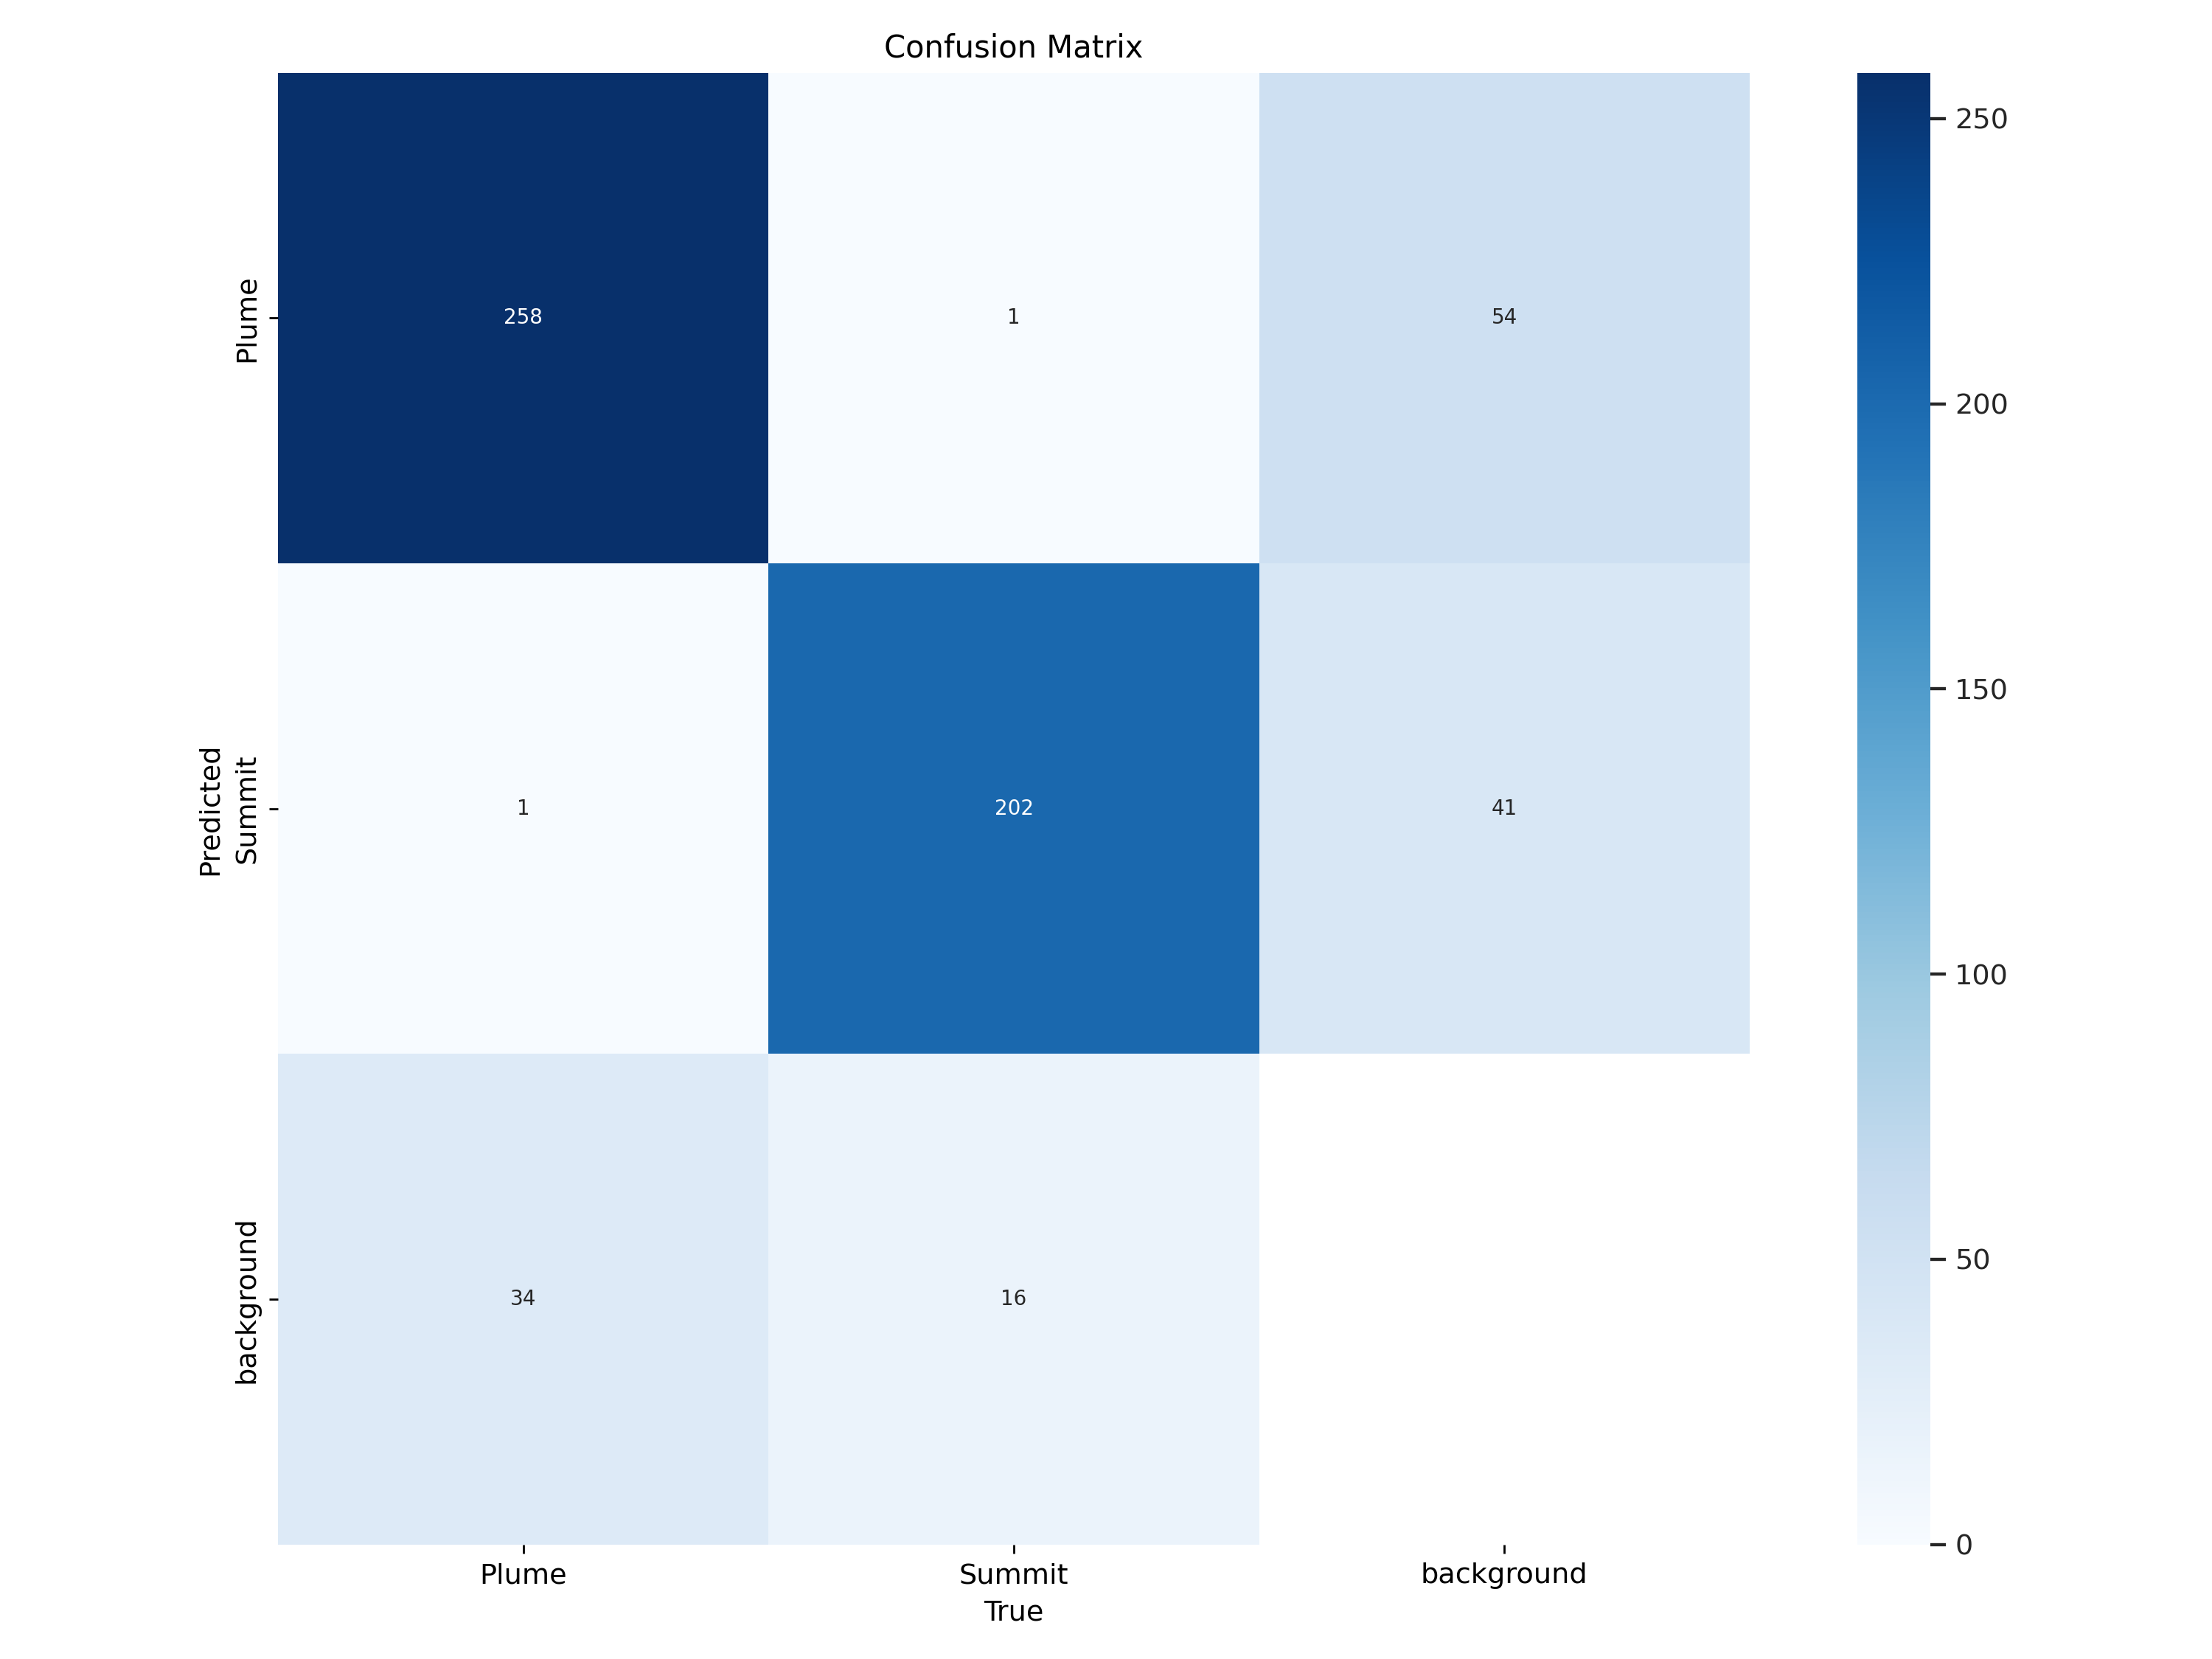

In [9]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


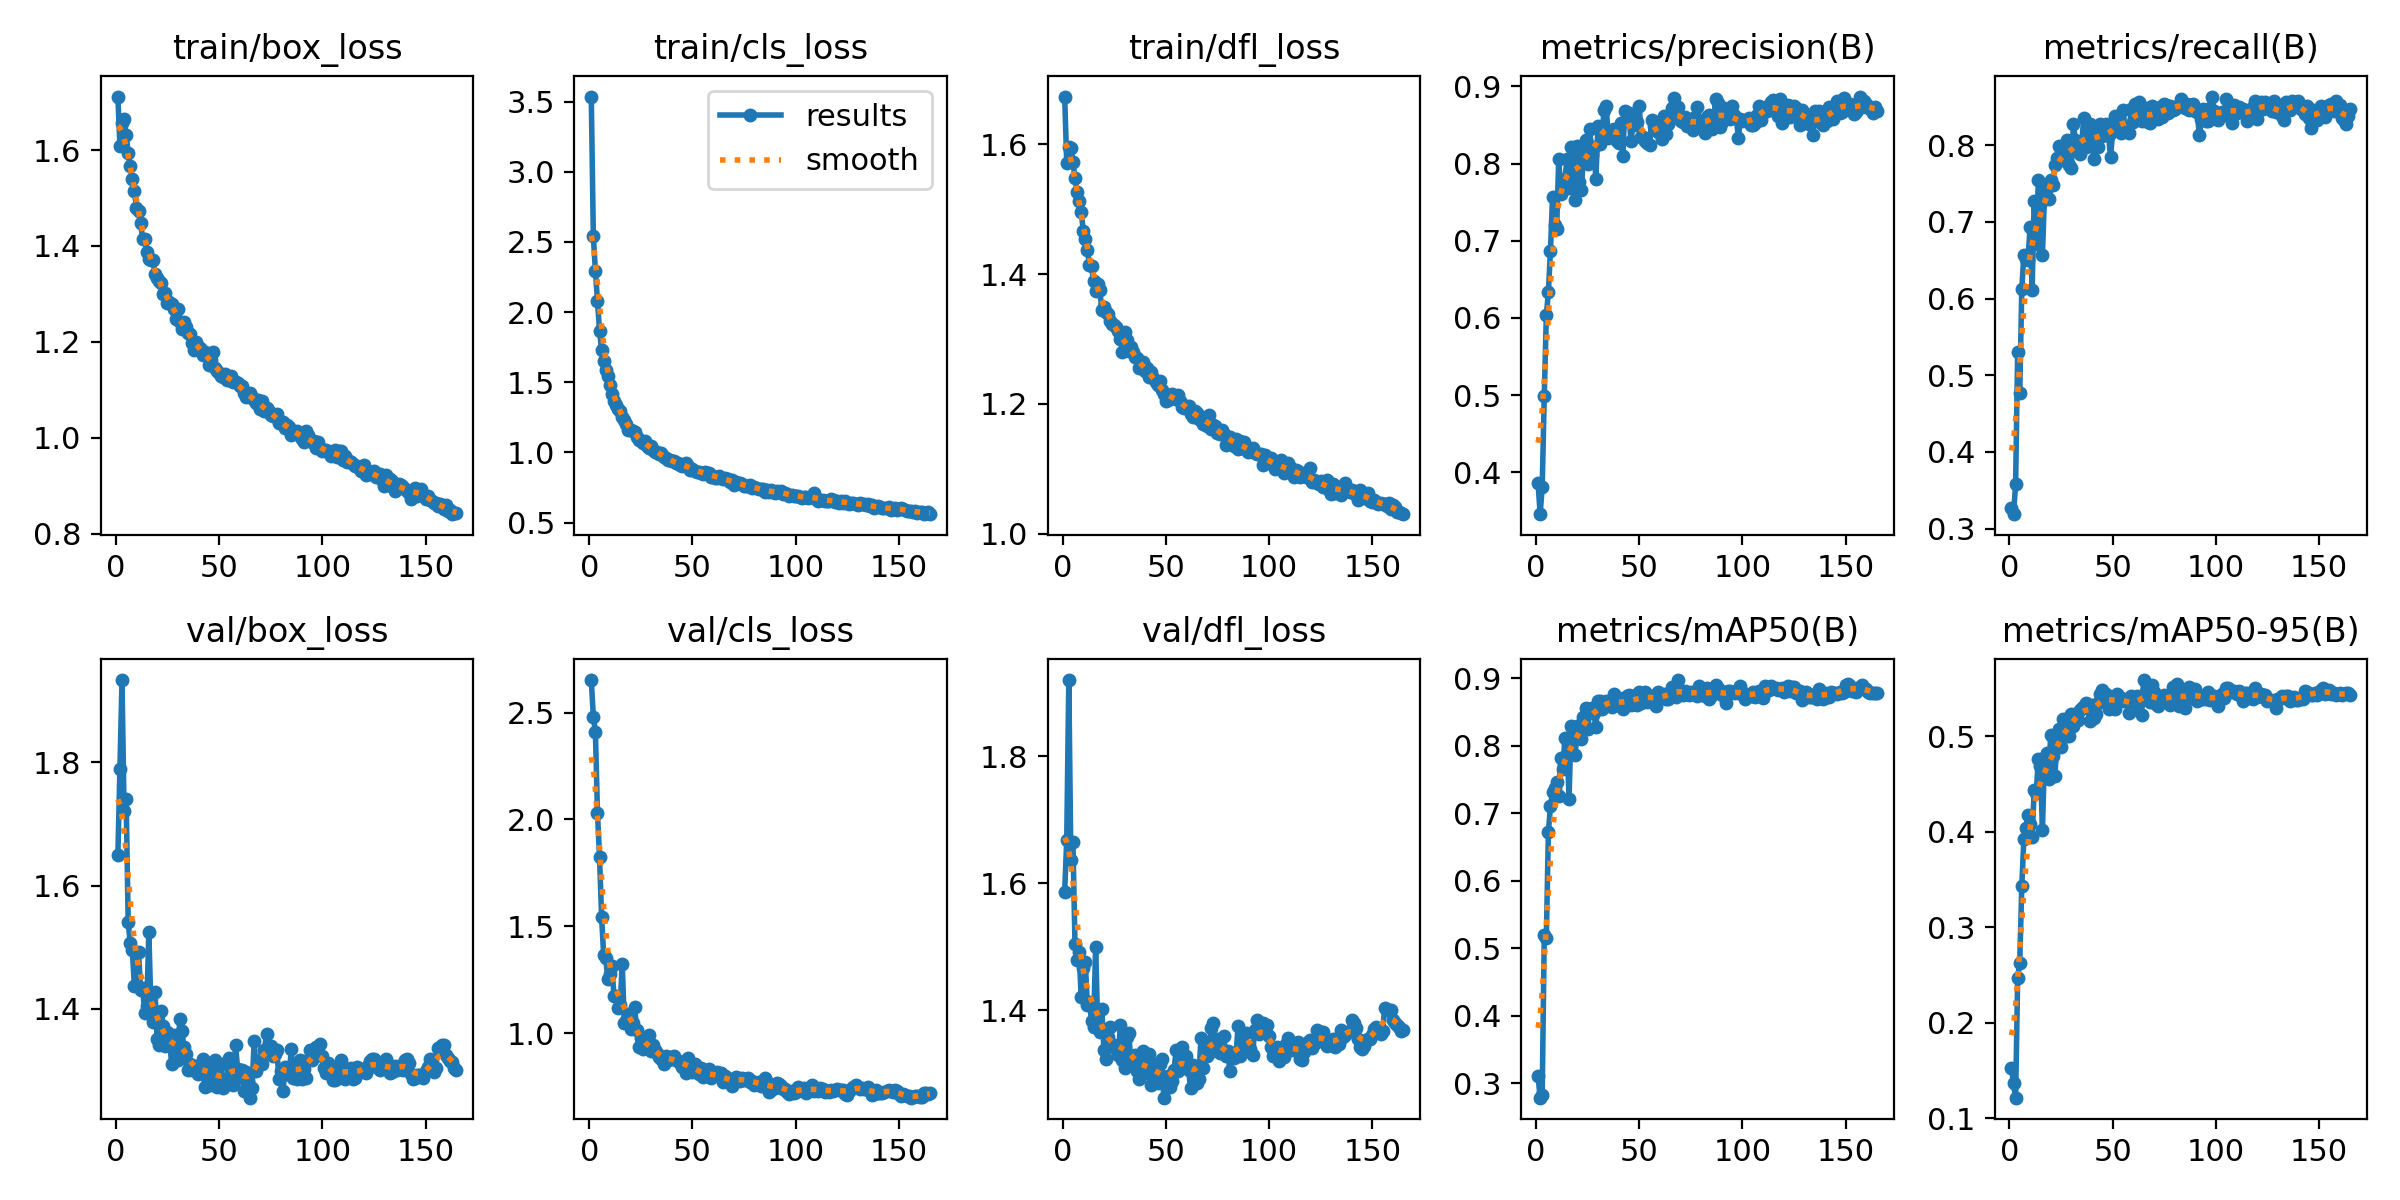

In [10]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


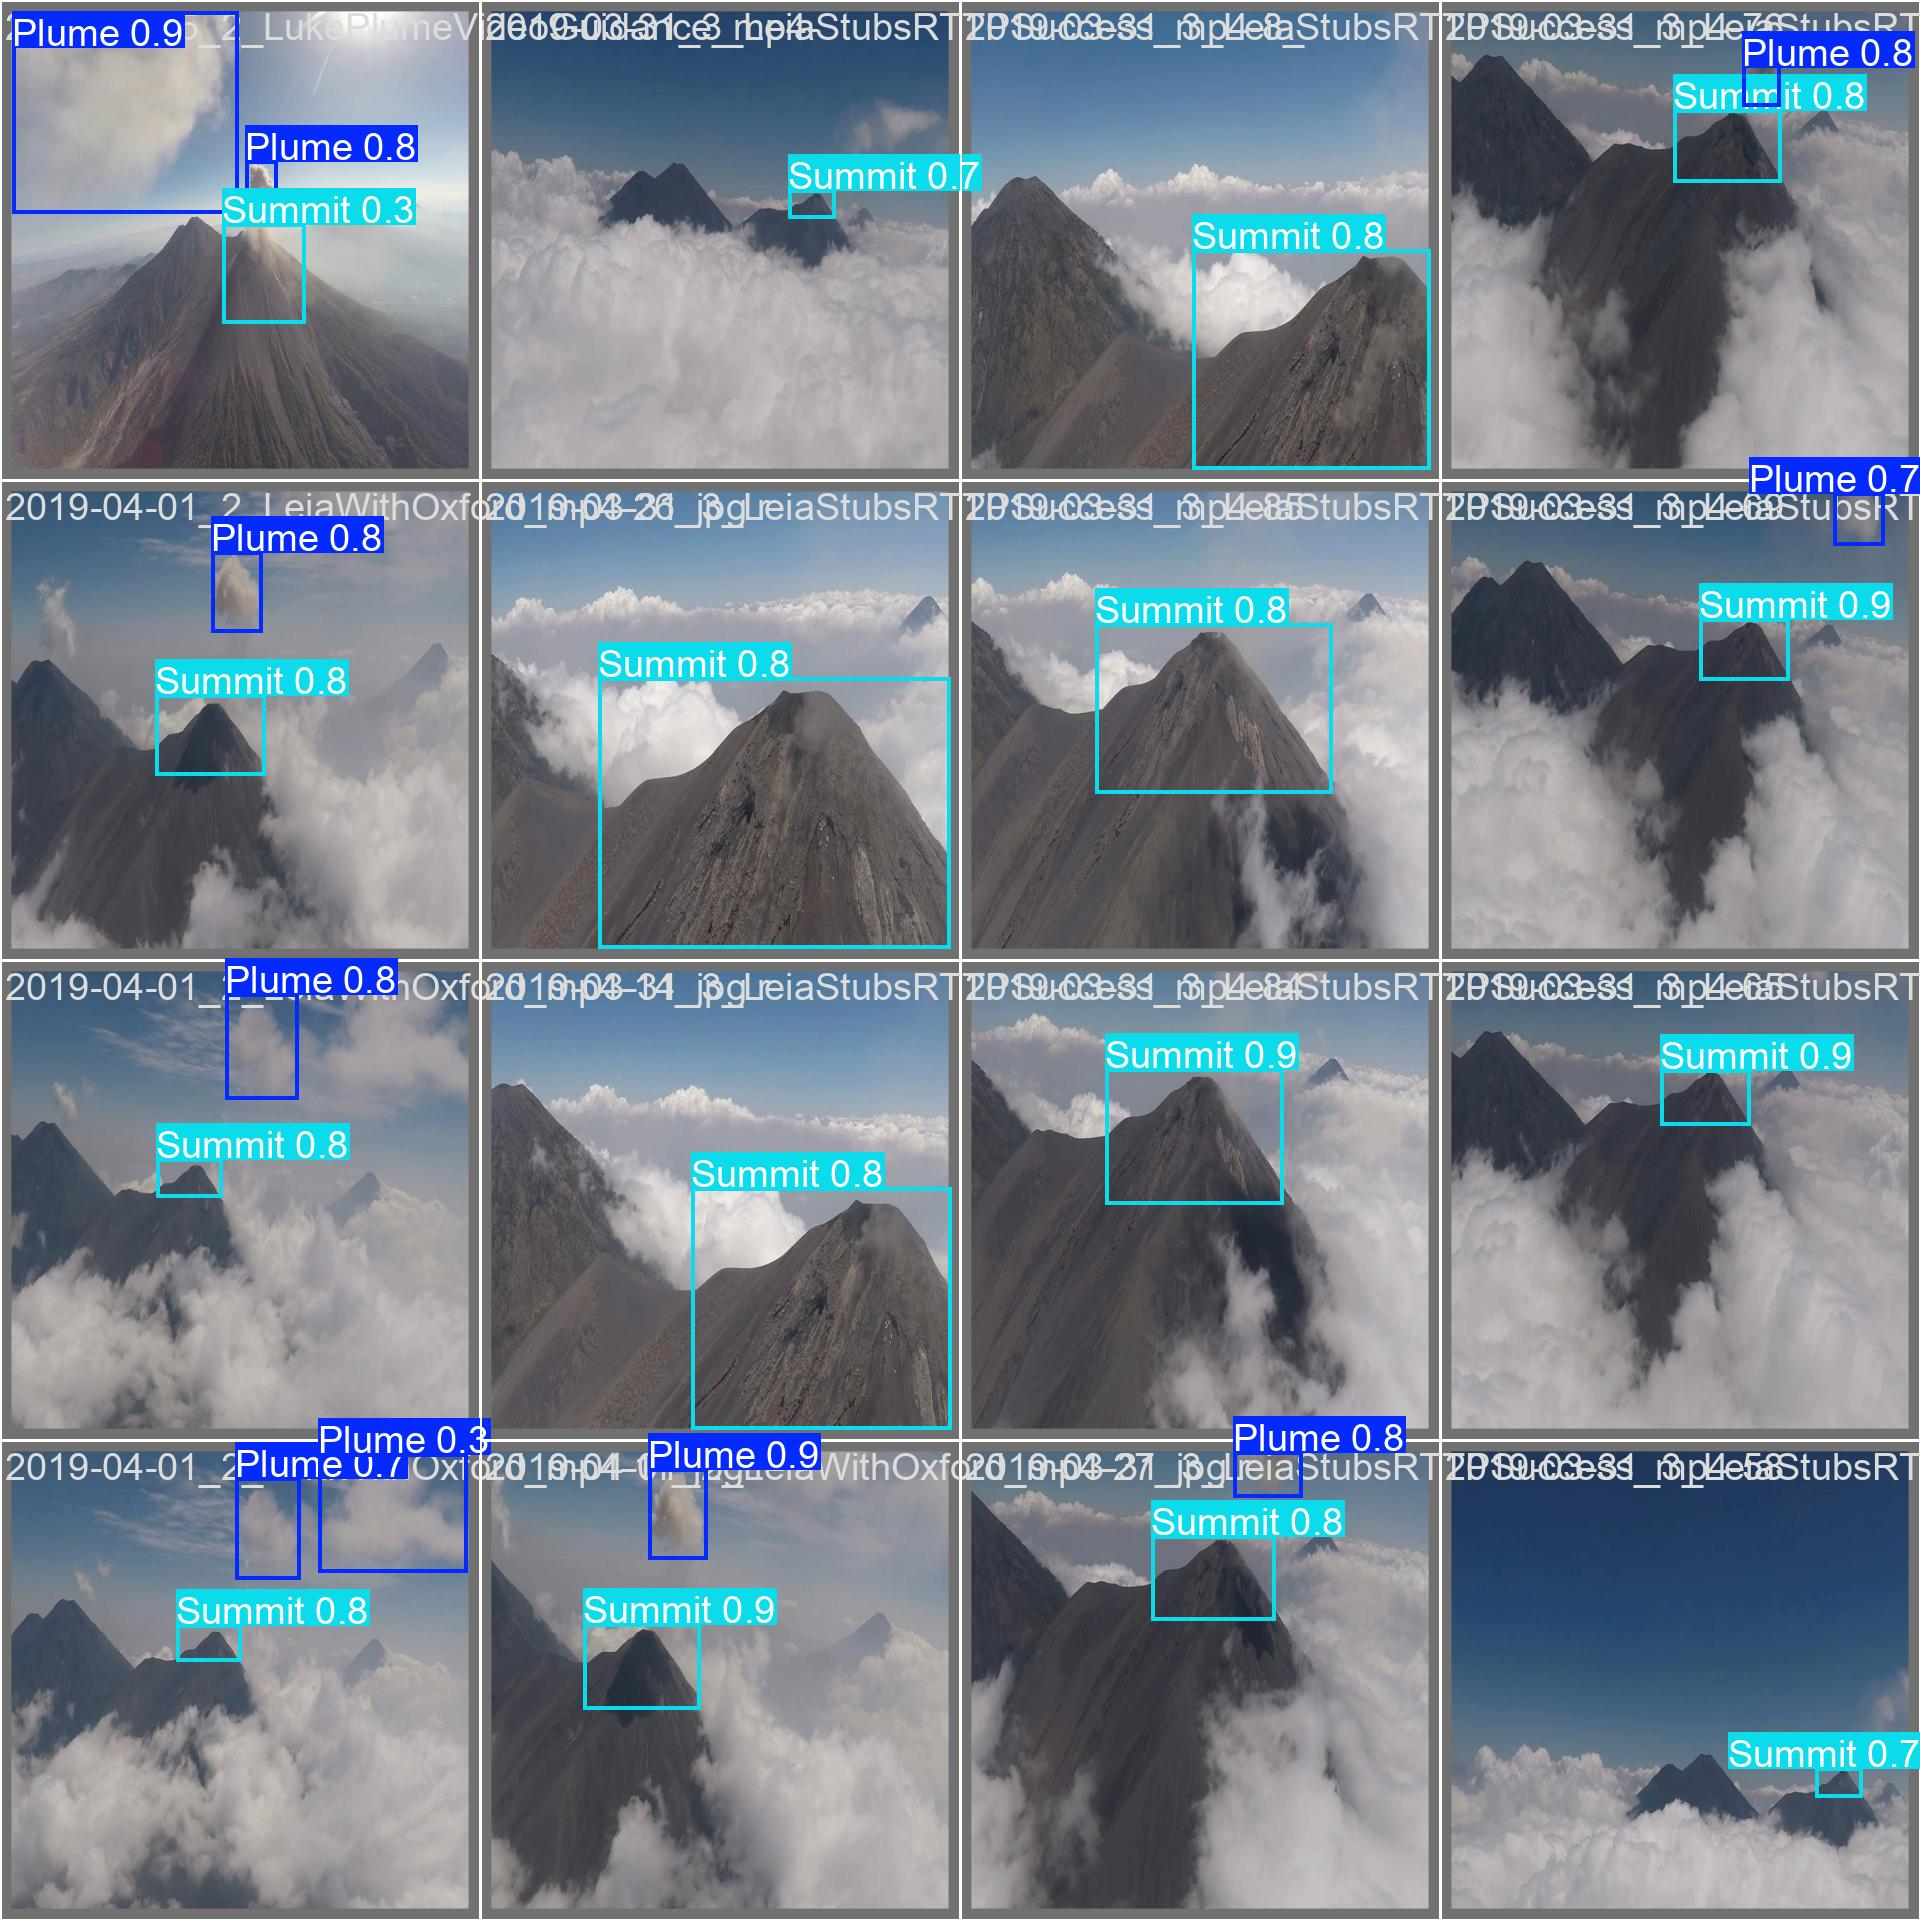

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate Custom Model

In [13]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=/content/data.yaml

/content
Ultralytics YOLOv8.2.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Scanning /content/object_detection_set_B/valid/labels.cache... 294 images, 0 backgrounds, 0 corrupt: 100% 294/294 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:04<00:00,  4.36it/s]
                   all        294        512      0.861      0.842      0.878      0.558
                 Plume        213        293      0.855      0.857      0.884      0.619
                Summit        218        219      0.866      0.826      0.872      0.497
Speed: 1.3ms preprocess, 4.8ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [4]:
import shutil
import os

destination = "/content/drive/My Drive/backup_folder"

# Remove the folder if it exists
if os.path.exists(destination):
    shutil.rmtree(destination)

# Copy the directory
shutil.copytree(source, destination)


FileExistsError: [Errno 17] File exists: '/content/drive/My Drive/backup_folder'